## Installing dependencies from Poetry package

In [3]:
!poetry install

Creating virtualenv poetrytest-package-0KF3zjNZ-py3.7 in C:\Users\Noor\AppData\Local\pypoetry\Cache\virtualenvs
Installing dependencies from lock file


Package operations: 38 installs, 0 updates, 0 removals

  - Installing more-itertools (8.0.2)
  - Installing numpy (1.17.4)
  - Installing six (1.13.0)
  - Installing cycler (0.10.0)
  - Installing joblib (0.14.1)
  - Installing kiwisolver (1.1.0)
  - Installing llvmlite (0.30.0)
  - Installing pyparsing (2.4.5)
  - Installing python-dateutil (2.8.1)
  - Installing pytz (2019.3)
  - Installing scipy (1.3.3)
  - Installing zipp (0.6.0)
  - Installing decorator (4.4.1)
  - Installing h5py (2.10.0)
  - Installing importlib-metadata (1.3.0)
  - Installing matplotlib (3.0.3)
  - Installing natsort (6.2.0)
  - Installing numba (0.46.0)
  - Installing numexpr (2.7.0)
  - Installing pandas (0.25.3)
  - Installing patsy (0.5.1)
  - Installing scikit-learn (0.22)
  - Installing anndata (0.6.22.post1)
  - Installing atomicwrites (1.3.0)
  - Insta

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
sc.settings.verbosity = 3
sc.logging.print_versions()
results_file = './write/kidney_allograft_rejection.h5ad'

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.4 scipy==1.3.0 pandas==0.25.3 scikit-learn==0.21.2 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1


In [5]:
sc.settings.set_figure_params(dpi=80)

In [6]:
!pwd
!ls kidney_allograft_rejection/

/Users/khunzawlatt/Desktop/Python_course/sc309
ls: kidney_allograft_rejection/: No such file or directory


## Reading single cell data from a text file

In [4]:
adata = sc.read_text(
    '/Users/khunzawlatt/Desktop/Python_course/sc309_copy/kidney_allograft_rejection/Kidney_allo_rejection_python_input.txt')  # the directory with the `.mtx` file
    # use gene symbols for the variable names (variables-axis index)

NameError: name 'sc' is not defined

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


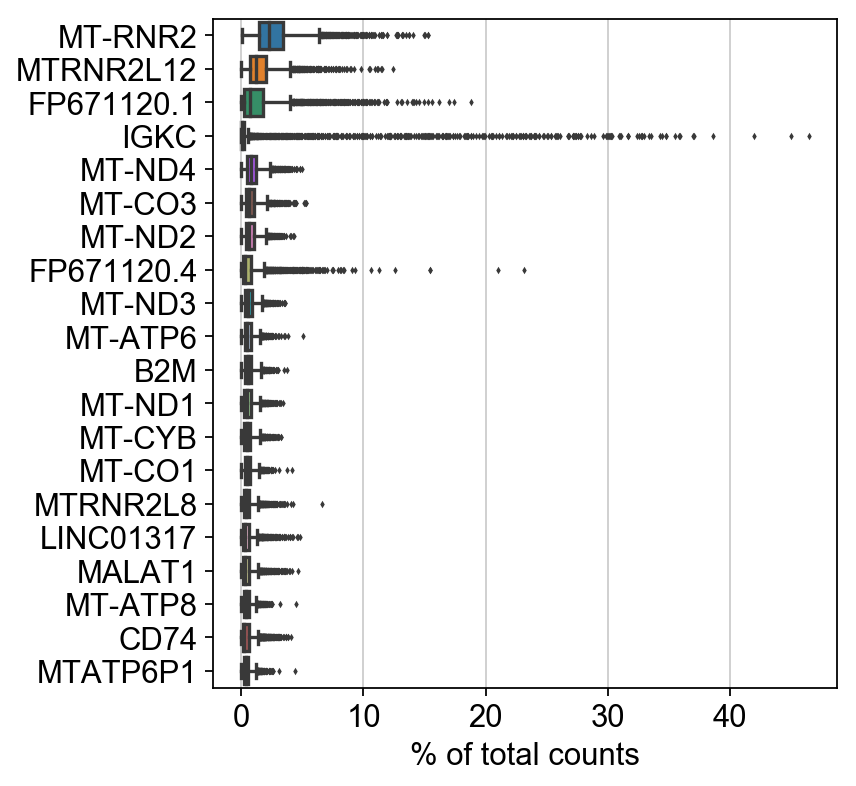

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Filtering cells and Normalization

In [9]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [10]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1)

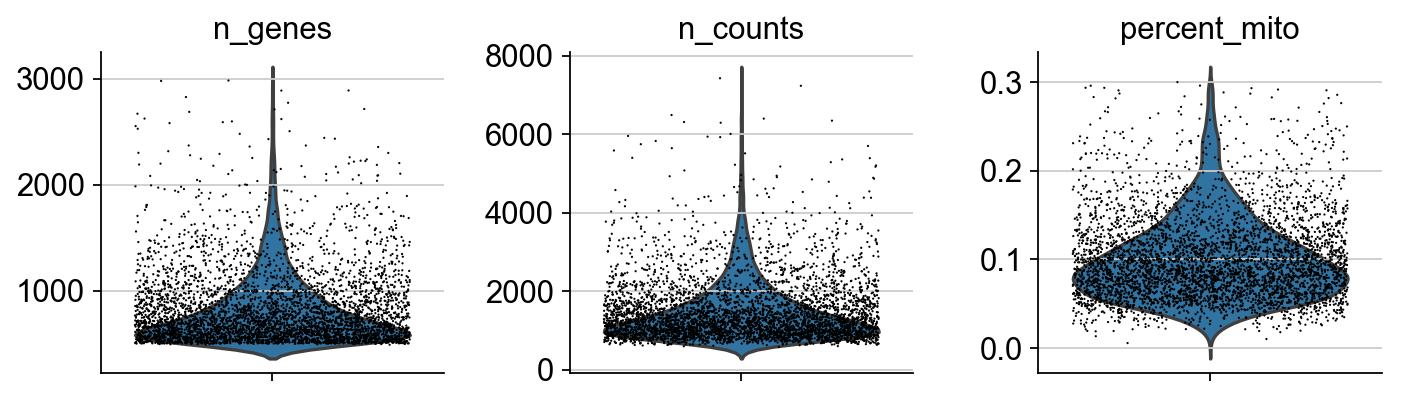

In [11]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

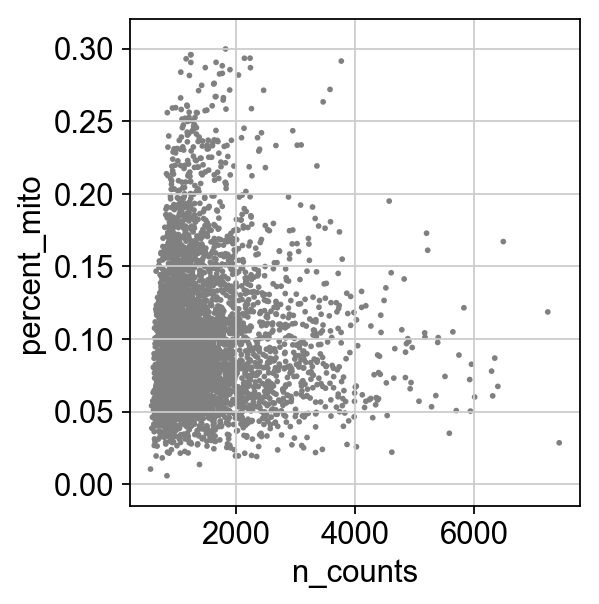

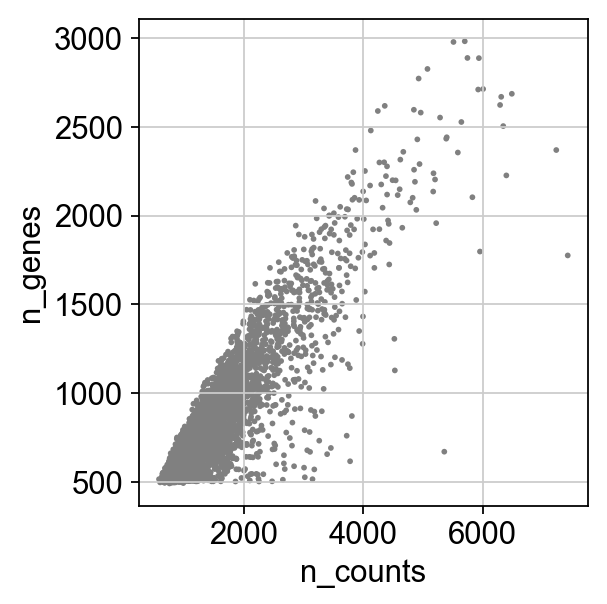

In [12]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [13]:
adata

AnnData object with n_obs × n_vars = 4487 × 20477 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [16]:
sc.pp.log1p(adata)

In [17]:
#adata.raw = adata

In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


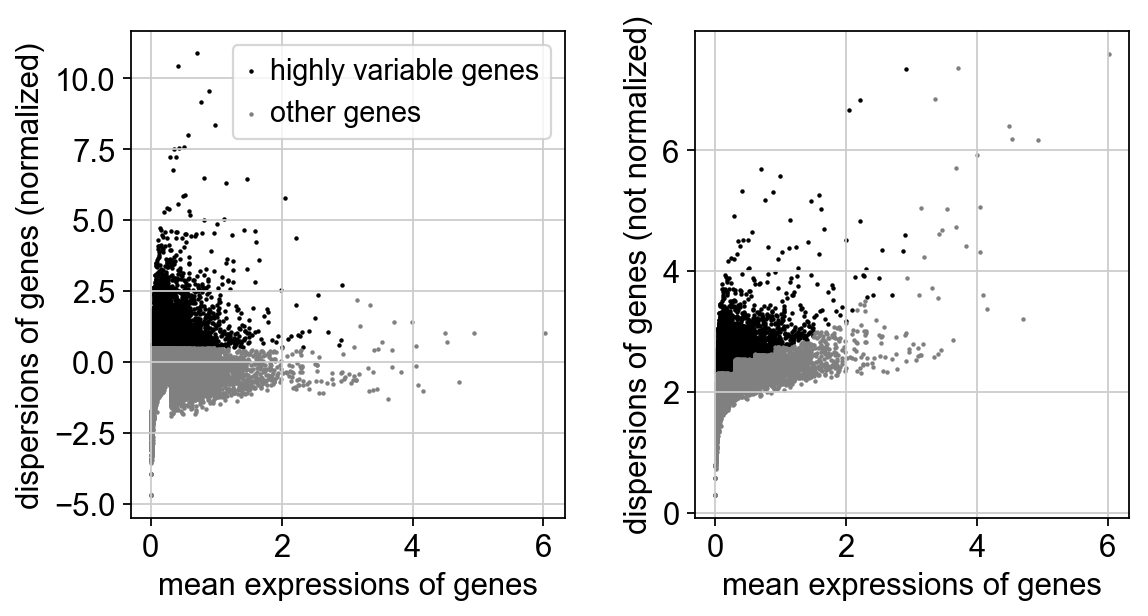

In [19]:
sc.pl.highly_variable_genes(adata)

In [20]:
adata = adata[:, adata.var['highly_variable']]

In [21]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']


//anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


    finished (0:00:20)


In [1]:
sc.pp.scale(adata, max_value=10)

NameError: name 'sc' is not defined

In [ ]:
def zero_normalize(df_to_norm):

    """
    zero_normalize(df_to_norm)
    
    Averages the 0 kGy dose readings for each condition and triplicate for an input data frame (df_to_norm), then
    normalizes the other dose readings by the zero average.
    """
    
    zero_normed_df = pd.DataFrame()
    for idx, condi in df_to_norm.groupby(level='Condition'):
        condi = condi.apply(lambda x: x / (condi['0'].mean(axis=1)))
        zero_normed_df = zero_normed_df.append(condi)
    return zero_normed_df

In [5]:
def filterRegress(SingleCellData):
    """
    Filters genes and cells, normalizes the data, determines highly variable genes, calculates percentage of mitochondrial genes, and regresses out the total counts and mitochondrial percentage.
    """
    sc.pp.filter_cells(SingleCellData, min_genes=200)
    sc.pp.filter_genes(SingleCellData, min_cells=3)
    
    mito_genes = SingleCellData.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
    SingleCellData.obs['percent_mito'] = np.sum(
    SingleCellData[:, mito_genes].X, axis=1) / np.sum(SingleCellData.X, axis=1)
# add the total counts per cell as observations-annotation to adata
    SingleCellData.obs['n_counts'] = SingleCellData.X.sum(axis=1)
    
    SingleCellData = SingleCellData[SingleCellData.obs['n_genes'] < 2500, :]
    SingleCellData = SingleCellData[SingleCellData.obs['percent_mito'] < 0.05, :]
    
    sc.pp.normalize_per_cell(SingleCellData, counts_per_cell_after=1e4)
    
    sc.pp.log1p(SingleCellData)
    
    sc.pp.highly_variable_genes(SingleCellData, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    SingleCellData = SingleCellData[:, SingleCellData.var['highly_variable']]
    sc.pp.regress_out(SingleCellData, ['n_counts', 'percent_mito'])

In [3]:
filterRegress(adata)

NameError: name 'adata' is not defined

## PCA and UMAP

In [23]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


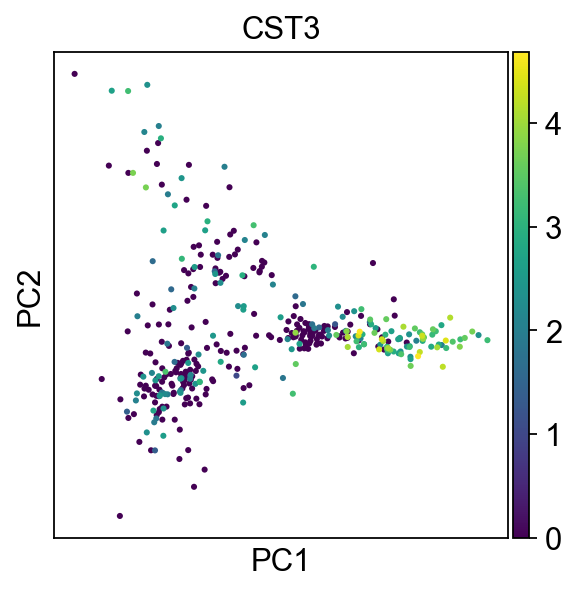

In [24]:
sc.pl.pca(adata, color='CST3', size=30)

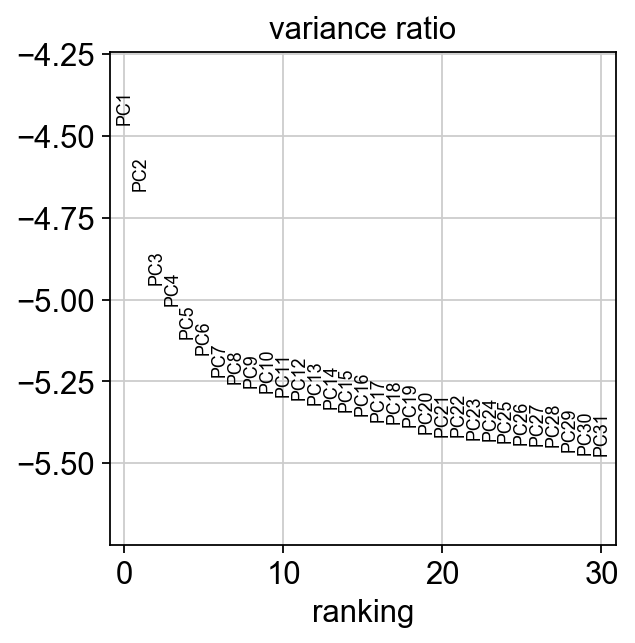

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

In [26]:
adata.write(results_file)

In [27]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)


In [28]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


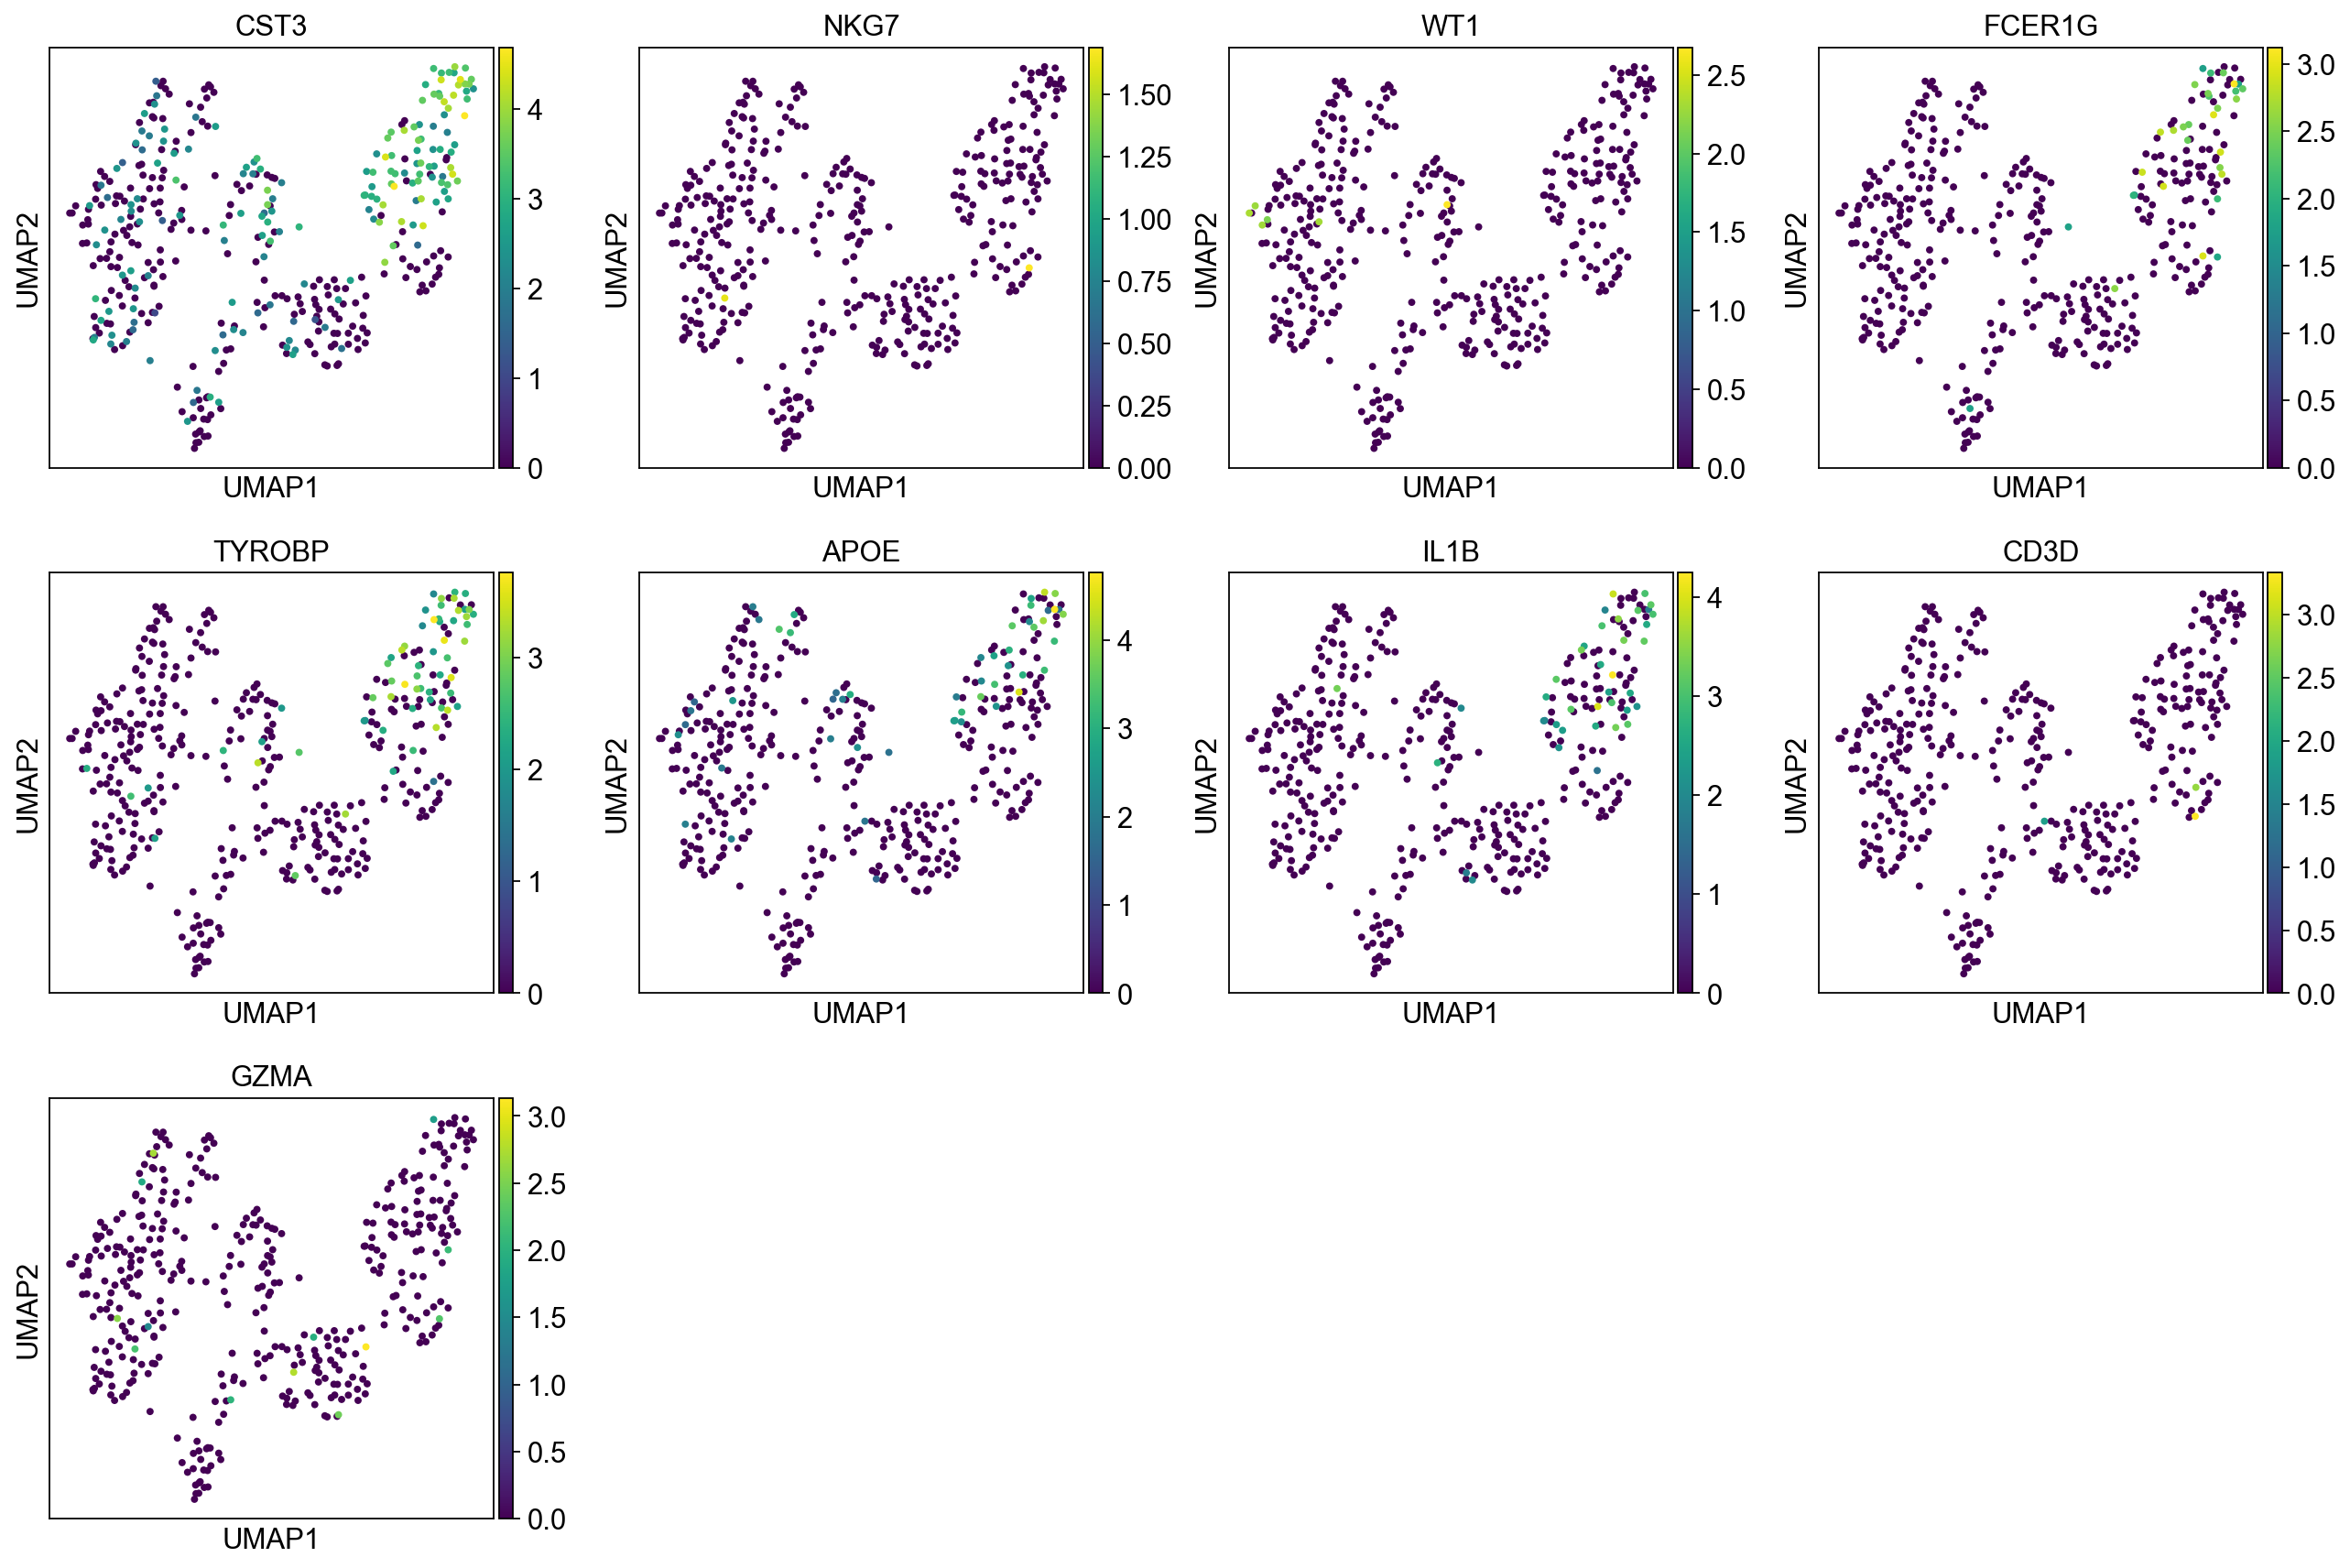

In [29]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'WT1', 'FCER1G', 'TYROBP', 'APOE', 'IL1B', 'CD3D', 'GZMA'], size = 50)

In [30]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


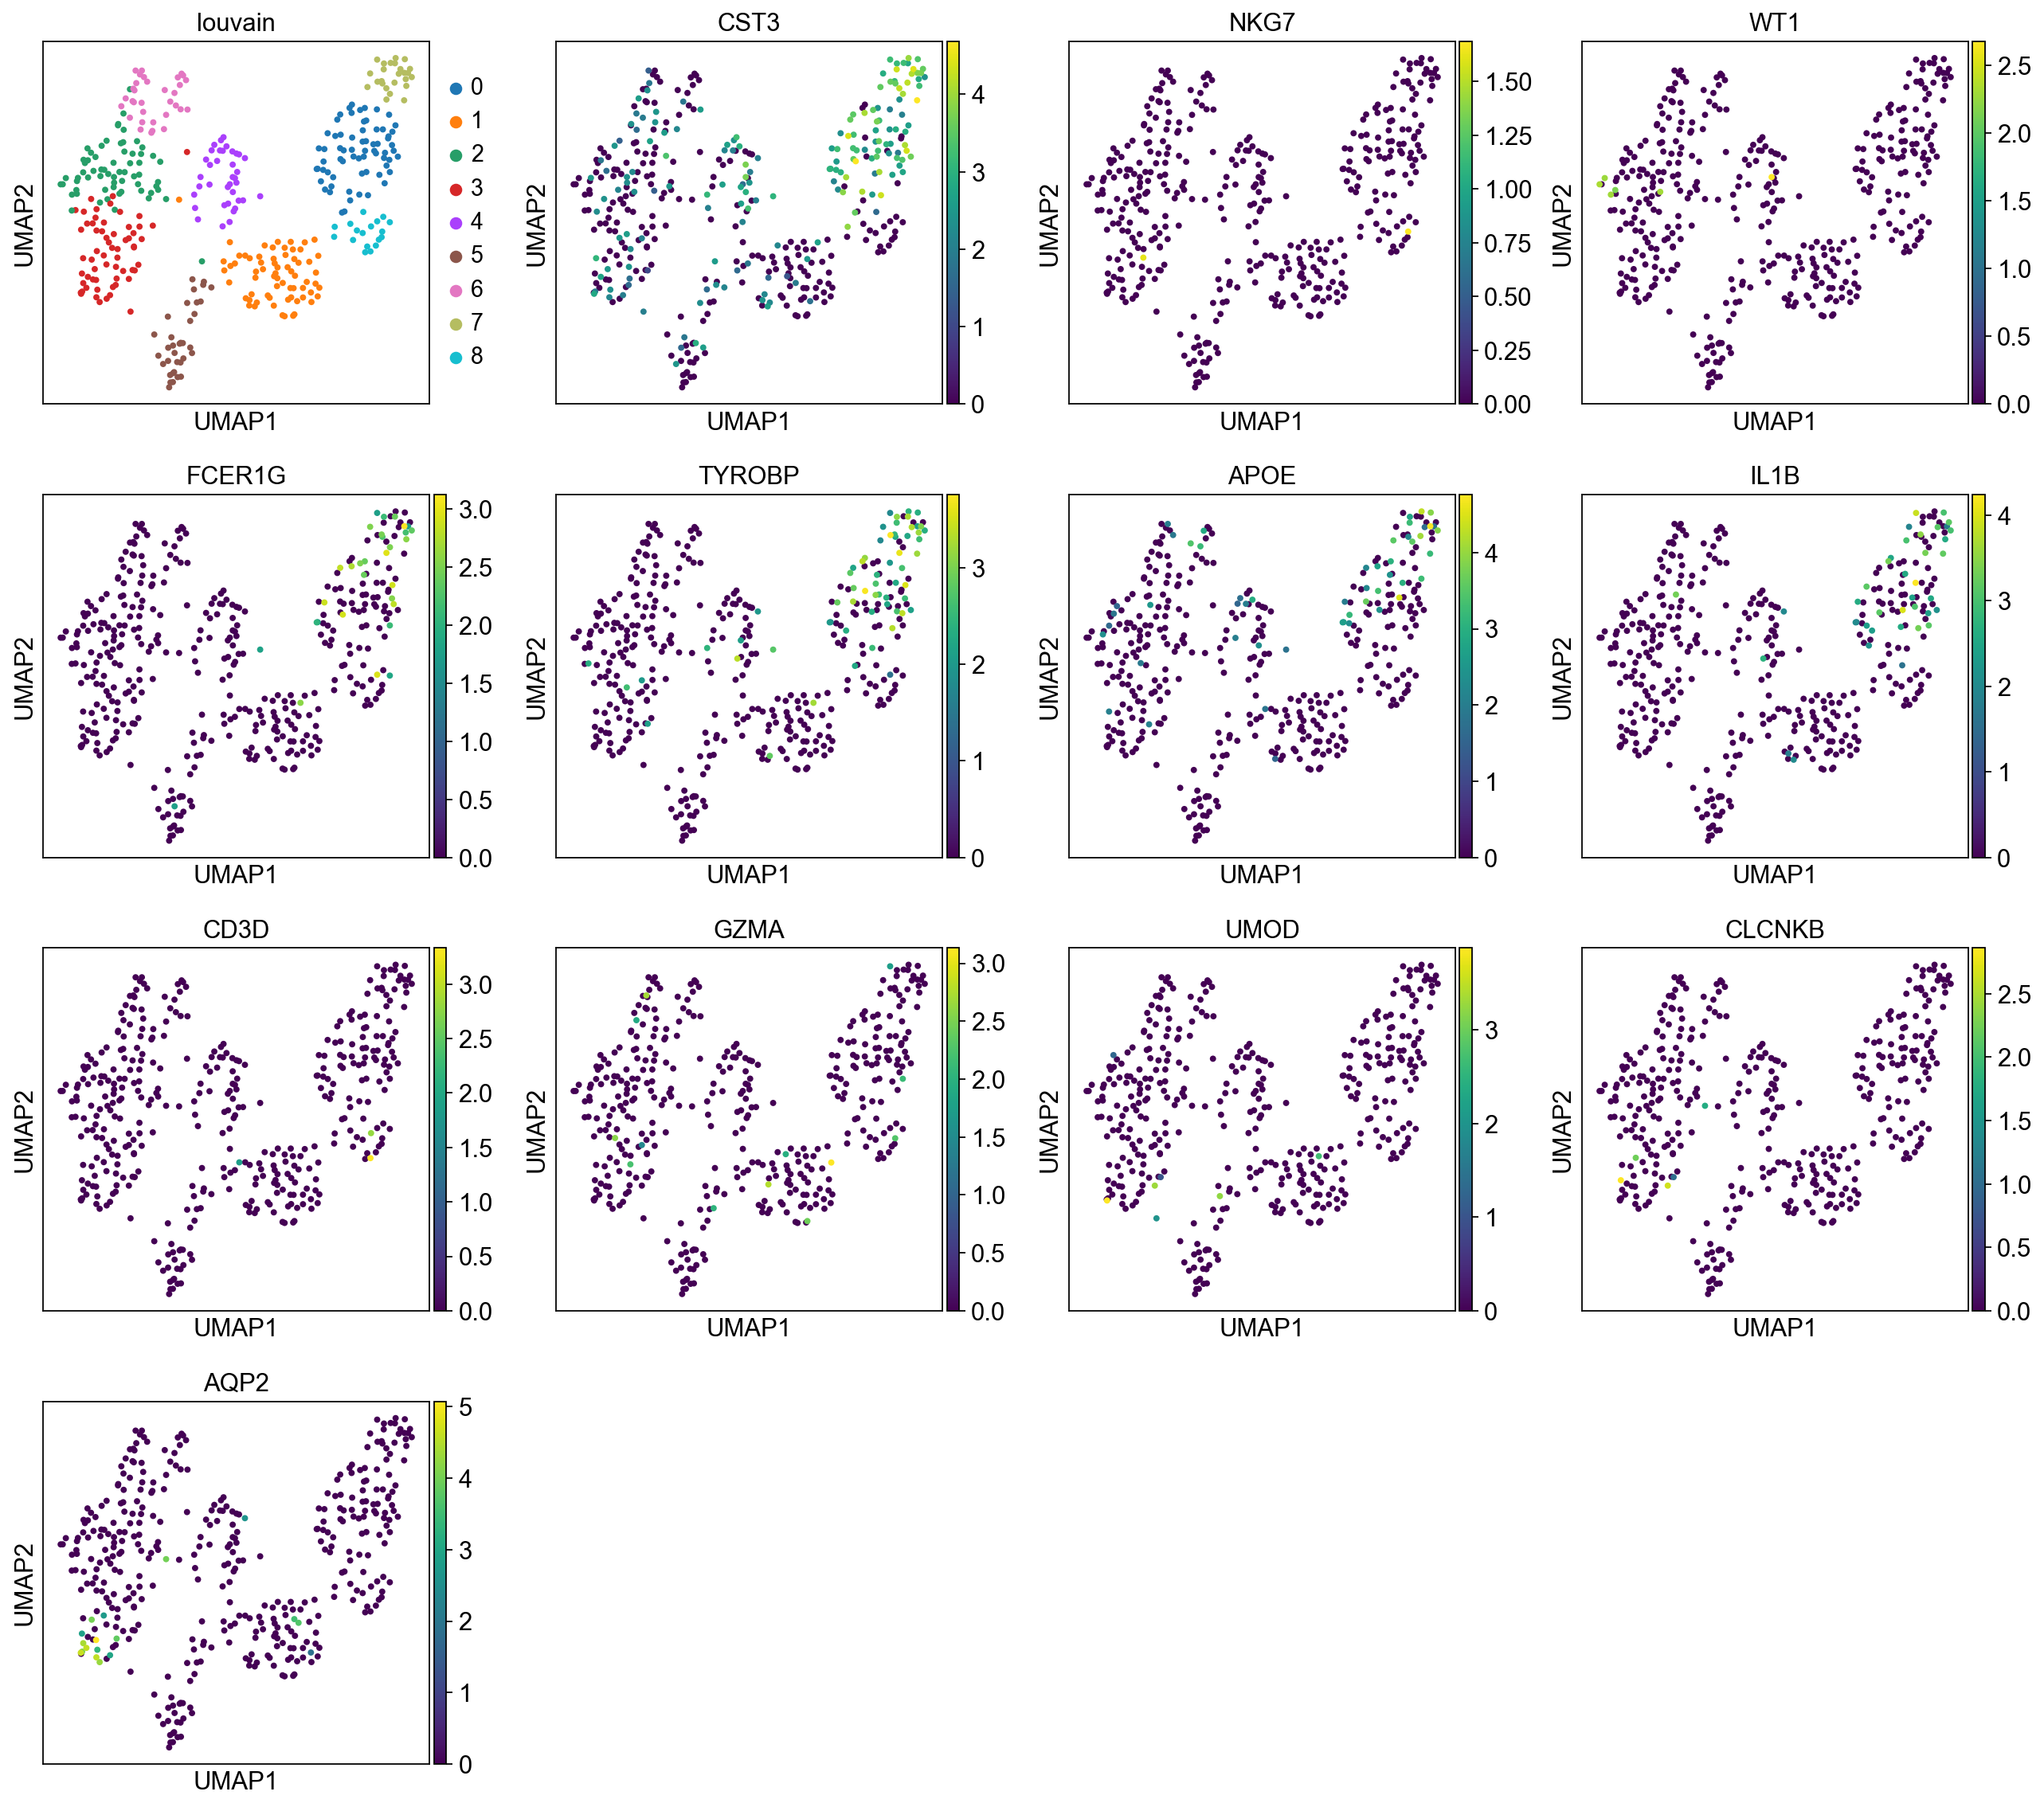

In [31]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7', 'WT1', 'FCER1G', 'TYROBP', 'APOE', 'IL1B', 'CD3D', 'GZMA', 'UMOD', 'CLCNKB', 'AQP2'], size = 50)

In [32]:
adata.write(results_file)

## Finding top genes for each cluster

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


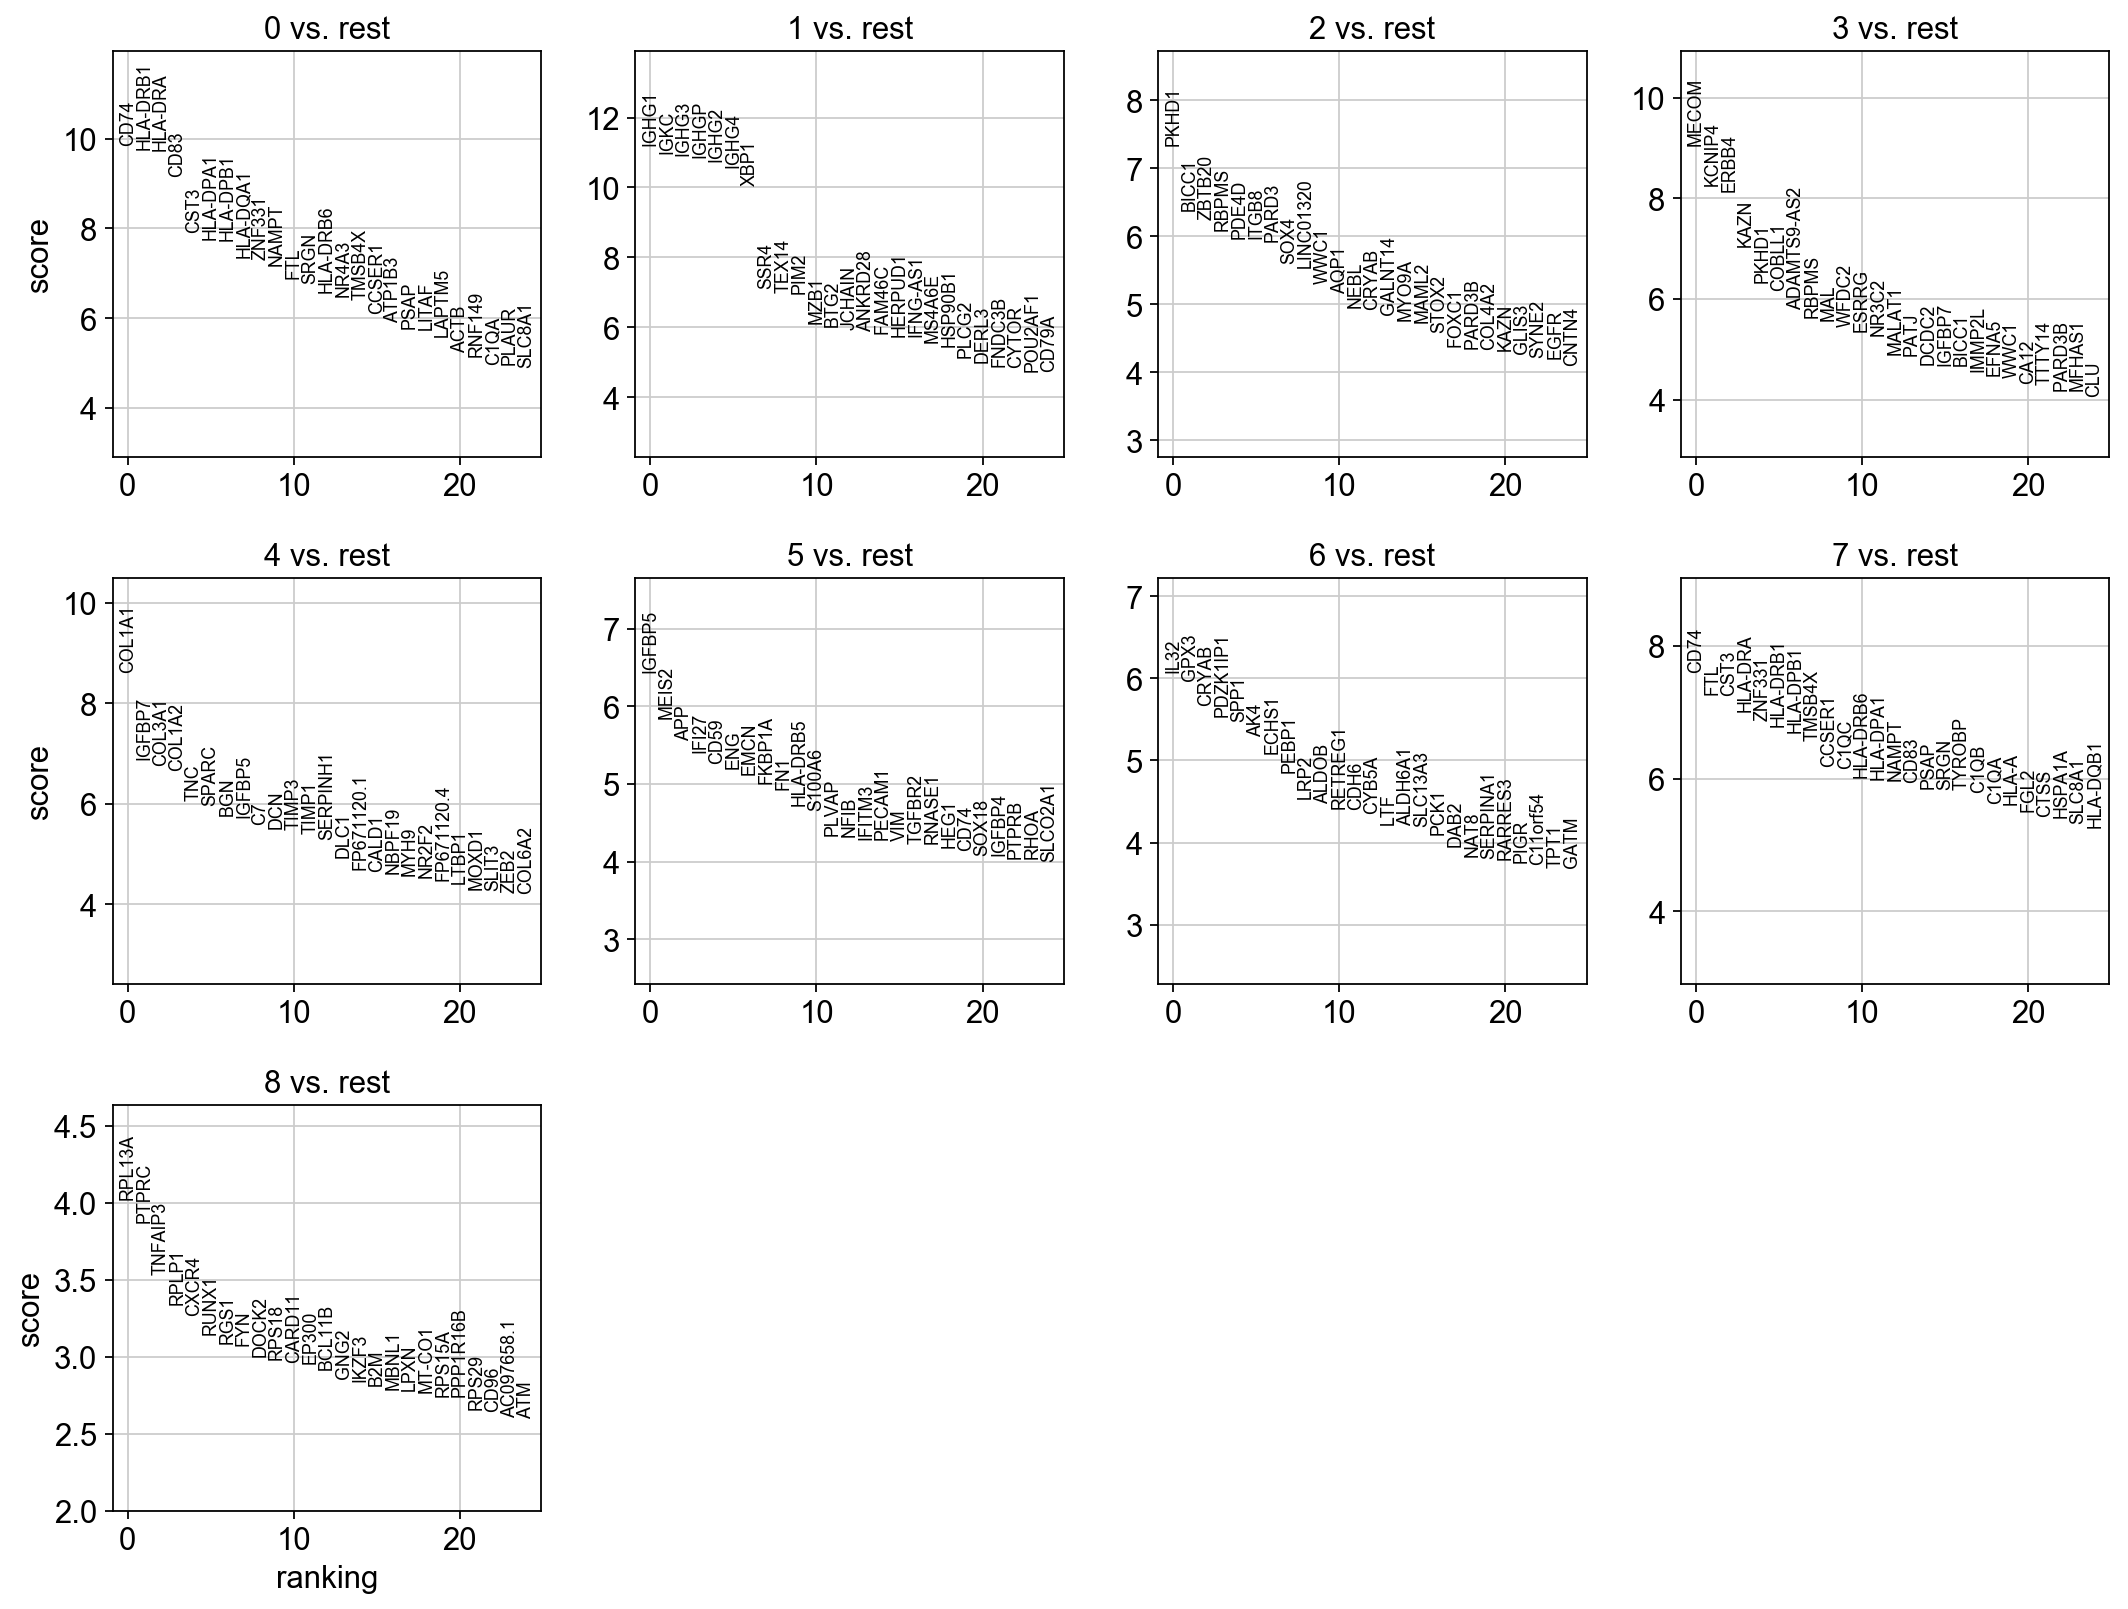

In [33]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
adata.write(results_file)

In [35]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

,0,1,2,3,4,5,6,7,8
0,CD74,IGHG1,PKHD1,MECOM,COL1A1,IGFBP5,IL32,CD74,RPL13A
1,HLA-DRB1,IGKC,BICC1,KCNIP4,IGFBP7,MEIS2,GPX3,FTL,PTPRC
2,HLA-DRA,IGHG3,ZBTB20,ERBB4,COL3A1,APP,CRYAB,CST3,TNFAIP3
3,CD83,IGHGP,RBPMS,KAZN,COL1A2,IFI27,PDZK1IP1,HLA-DRA,RPLP1
4,CST3,IGHG2,PDE4D,PKHD1,TNC,CD59,SPP1,ZNF331,CXCR4
5,HLA-DPA1,IGHG4,ITGB8,COBLL1,SPARC,ENG,AK4,HLA-DRB1,RUNX1
6,HLA-DPB1,XBP1,PARD3,ADAMTS9-AS2,BGN,EMCN,ECHS1,HLA-DPB1,RGS1
7,HLA-DQA1,SSR4,SOX4,RBPMS,IGFBP5,FKBP1A,PEBP1,TMSB4X,FYN
8,ZNF331,TEX14,LINC01320,MAL,C7,FN1,LRP2,CCSER1,DOCK2
9,NAMPT,PIM2,WWC1,WFDC2,DCN,HLA-DRB5,ALDOB,C1QC,RPS18


In [2]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(15)

NameError: name 'adata' is not defined

## Visualizing genes

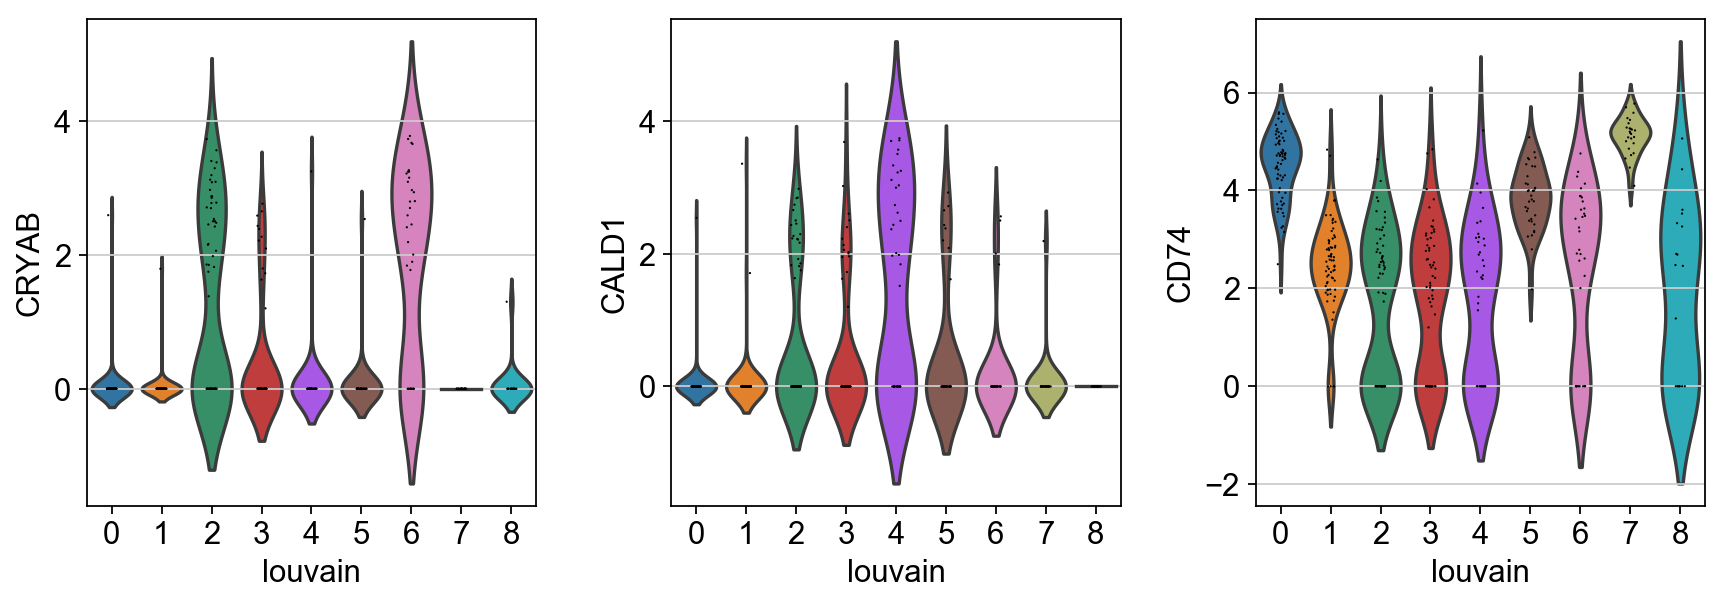

In [37]:
sc.pl.violin(adata, ['CRYAB', 'CALD1', 'CD74'], groupby='louvain')

In [38]:
marker_genes = ['MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'IL1B', 'APOE', 'KLRB1',
                'FCGR3A', 'FCER1A', 'CST3', 'WT1', 'IGFBP7']

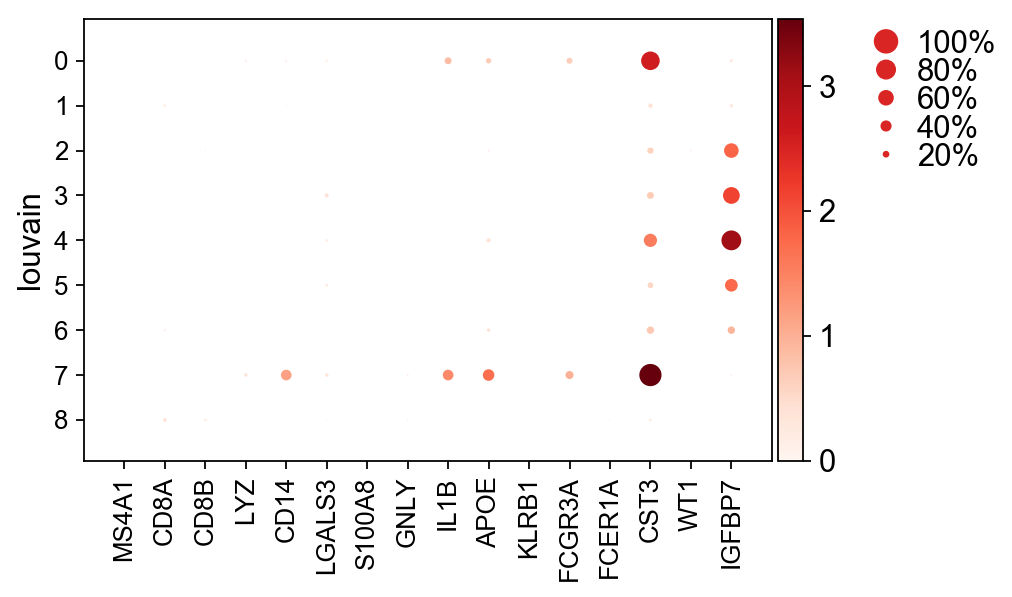

In [39]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')